# Installation

In [17]:
import os
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from torchsummary import summary

In [16]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Copy custom dataset from Google Drive to local storage
local_data_path = '/content/digits'
if not os.path.exists(local_data_path):
    shutil.copytree('/content/drive/MyDrive/Dataset/digits', local_data_path)

# Custom Datasets and Noises

In [8]:
# Custom transformation to add Gaussian noise
class AddGaussianNoise:

    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Custom transformation to add Salt-and-Pepper noise
class AddSaltPepperNoise:
    def __init__(self, salt_prob=0.01, pepper_prob=0.01):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, tensor):
        img = tensor.numpy()
        noise = np.random.random(img.shape)
        img[noise < self.salt_prob] = 1.0
        img[noise > (1 - self.pepper_prob)] = 0.0
        return torch.from_numpy(img)

    def __repr__(self):
        return self.__class__.__name__ + '(salt_prob={0}, pepper_prob={1})'.format(self.salt_prob, self.pepper_prob)

# CNN model architecture

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x # output the logits

# Training Functioin

In [10]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_loss /= len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss, accuracy

# Test Function

In [11]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return test_loss, accuracy

# Train and Evaluation

In [12]:
def train_and_evaluate(args, model, device, train_loader, test_loader, optimizer, scheduler, model_dir_prefix):
    test_losses, test_accuracies, train_losses, train_accuracies = [], [], [], []
    best_test_loss = float('inf')
    patience = 5
    no_improvement_count = 0

    model_dir = f"{model_dir_prefix}_seed_{args.seed}"
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    for epoch in range(1, args.epochs + 1):
        train_loss, train_accuracy = train(args, model, device, train_loader, optimizer, epoch)
        test_loss, test_accuracy = test(model, device, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            no_improvement_count = 0
            if args.save_model and (epoch > 2 or model_dir_prefix == "MNIST_Model"):
                model_filename = f"{model_dir_prefix.lower()}_epoch:{epoch}_test-accuracy:{test_accuracy:.4f}_test-loss:{test_loss:.4f}.pt"
                model_path = os.path.join(model_dir, model_filename)
                try:
                    torch.save(model.state_dict(), model_path)
                    print(f"Model saved with new best test loss: {best_test_loss:.4f} \n")
                except Exception as e:
                    print(f"Error saving model: {e}")
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"\nEarly stopping triggered after {epoch} epochs. No improvement in test loss for {patience} consecutive epochs.")
            break

        scheduler.step()

    return train_losses, train_accuracies, test_losses, test_accuracies

# Visualization

## The accuracy and loss of model for 50 epochs plot

In [13]:
def plot_results(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.plot(epochs, test_losses, 'o-', label='Test Loss')
    plt.title('Loss vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title('Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Display augmented images

In [14]:
def display_augmented_images():
    # Basic transformation
    transform_basic = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    # Transformation with Gaussian noise
    transform_gaussian = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.2, 0.2), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=1)], p=0.3),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddGaussianNoise(mean=0., std=0.1)], p=0.2)
    ])

    # Transformation with Salt-and-Pepper noise
    transform_salt_pepper = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.3)
    ])

    # Transformation for custom dataset
    transform_custom = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.2)
    ])

    # Load datasets
    dataset_basic = datasets.MNIST('../data', train=True, download=True, transform=transform_basic)
    dataset_gaussian = datasets.MNIST('../data', train=True, download=True, transform=transform_gaussian)
    dataset_salt_pepper = datasets.MNIST('../data', train=True, download=True, transform=transform_salt_pepper)
    dataset_custom = datasets.ImageFolder(root='/content/digits', transform=transform_custom)

    # Display images
    for dataset, title, idx in [
        (dataset_basic, 'Basic', 0),
        (dataset_gaussian, 'Gaussian Noise', 4),
        (dataset_salt_pepper, 'Salt-and-Pepper Noise', 4),
        (dataset_custom, 'Custom Dataset', random.randint(0, len(dataset_custom) - 1))
    ]:
        image, label = dataset[idx]
        image = image * 0.3081 + 0.1307  # Reverse normalization
        image = image.squeeze().numpy()
        plt.imshow(image, cmap='gray')
        plt.title(f'{title} - Label: {label}' + (f' (Index: {idx})' if title == 'Custom Dataset' else ''))
        plt.show()

# Main Function

In [18]:
def main():
    # Set random seed
    random_seed = random.randint(0, 100000)
    print(f"Using random seed: {random_seed}")
    torch.manual_seed(random_seed)
    random.seed(random_seed)

    # Argument parsing
    args = argparse.Namespace(
        batch_size=64,
        test_batch_size=128,
        epochs=20,
        lr=1,
        gamma=0.9,
        no_cuda=False,
        no_mps=False,
        dry_run=False,
        seed=random_seed,
        log_interval=10,
        save_model=True
    )

    # Device setup
    use_cuda = not args.no_cuda and torch.cuda.is_available()
    use_mps = not args.no_mps and torch.backends.mps.is_available()
    device = torch.device("cuda" if use_cuda else "mps" if use_mps else "cpu")
    torch.manual_seed(args.seed)

    # Data loader kwargs
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1, 'pin_memory': True, 'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Define transformations
    transform_train = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.RandomAffine(degrees=(-5,5), translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
        transforms.RandomApply([AddSaltPepperNoise(salt_prob=0.01, pepper_prob=0.01)], p=0.2)
    ])

    transform_test = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load MNIST dataset
    mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform_train)
    mnist_test = datasets.MNIST('../data', train=False, transform=transform_test)

    # Load custom dataset
    custom_dataset = datasets.ImageFolder(root=local_data_path, transform=transform_train)

    # Split custom dataset
    train_size = int(0.8 * len(custom_dataset))
    test_size = len(custom_dataset) - train_size
    custom_train, custom_test = random_split(custom_dataset, [train_size, test_size])
    custom_test.dataset.transform = transform_test

    # Combine datasets
    combined_train = ConcatDataset([mnist_train, custom_train])
    combined_test = ConcatDataset([mnist_test, custom_test])

    # Create data loaders
    train_loader_mnist = DataLoader(mnist_train, **train_kwargs)
    test_loader_mnist = DataLoader(mnist_test, **test_kwargs)
    train_loader_combined = DataLoader(combined_train, **train_kwargs)
    test_loader_combined = DataLoader(combined_test, **test_kwargs)

    # Display augmented images
    display_augmented_images()

    # Train MNIST model
    model_mnist = Net().to(device)
    optimizer_mnist = optim.Adadelta(model_mnist.parameters(), lr=args.lr)
    scheduler_mnist = StepLR(optimizer_mnist, step_size=1, gamma=args.gamma)
    train_losses_mnist, train_accuracies_mnist, test_losses_mnist, test_accuracies_mnist = train_and_evaluate(
        args, model_mnist, device, train_loader_mnist, test_loader_mnist, optimizer_mnist, scheduler_mnist, "MNIST_Model"
    )
    plot_results(train_losses_mnist, train_accuracies_mnist, test_losses_mnist, test_accuracies_mnist)

    # Save MNIST model
    model_path_mnist = f'/content/MNIST_Model_seed_{args.seed}'
    shutil.make_archive(model_path_mnist, 'zip', model_path_mnist)
    files.download(f'{model_path_mnist}.zip')

    # Train combined model
    model_combined = Net().to(device)
    optimizer_combined = optim.Adadelta(model_combined.parameters(), lr=args.lr)
    scheduler_combined = StepLR(optimizer_combined, step_size=1, gamma=args.gamma)
    train_losses_combined, train_accuracies_combined, test_losses_combined, test_accuracies_combined = train_and_evaluate(
        args, model_combined, device, train_loader_combined, test_loader_combined, optimizer_combined, scheduler_combined, "DigitNet_Model"
    )
    plot_results(train_losses_combined, train_accuracies_combined, test_losses_combined, test_accuracies_combined)

    # Save combined model
    model_path_combined = f'/content/DigitNet_Model_seed_{args.seed}'
    shutil.make_archive(model_path_combined, 'zip', model_path_combined)
    files.download(f'{model_path_combined}.zip')

Using random seed: 79381


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 65.5kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 246kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.82MB/s]


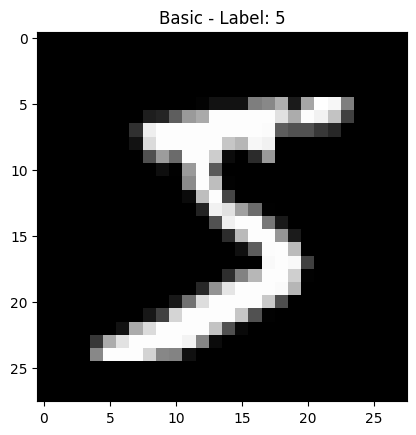

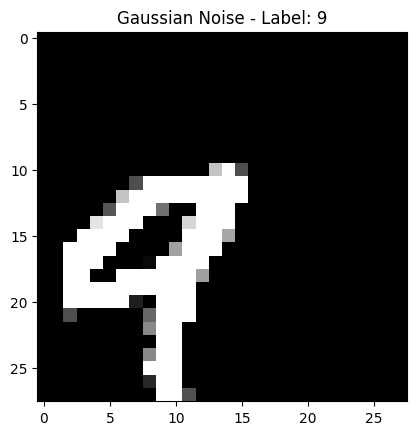

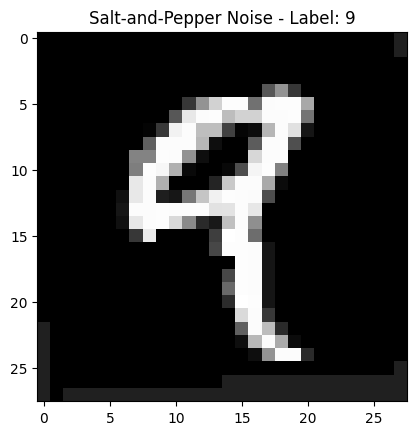

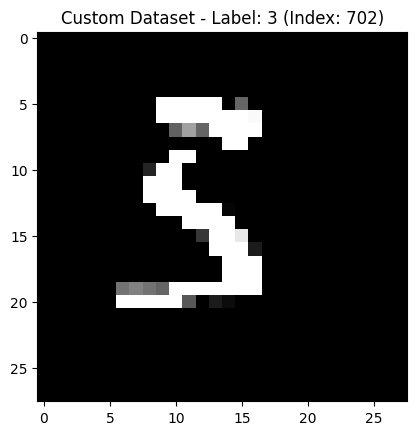

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299096
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.278366
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298532
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.095764
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.946910
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.009491
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.118658
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.663354
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.140910
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.571271
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.105075
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.866523
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.506109
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.652781
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.598915
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.623575
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.983563
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.582986
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.382340
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.191428
Train Epoch: 1 [12800/60000 (

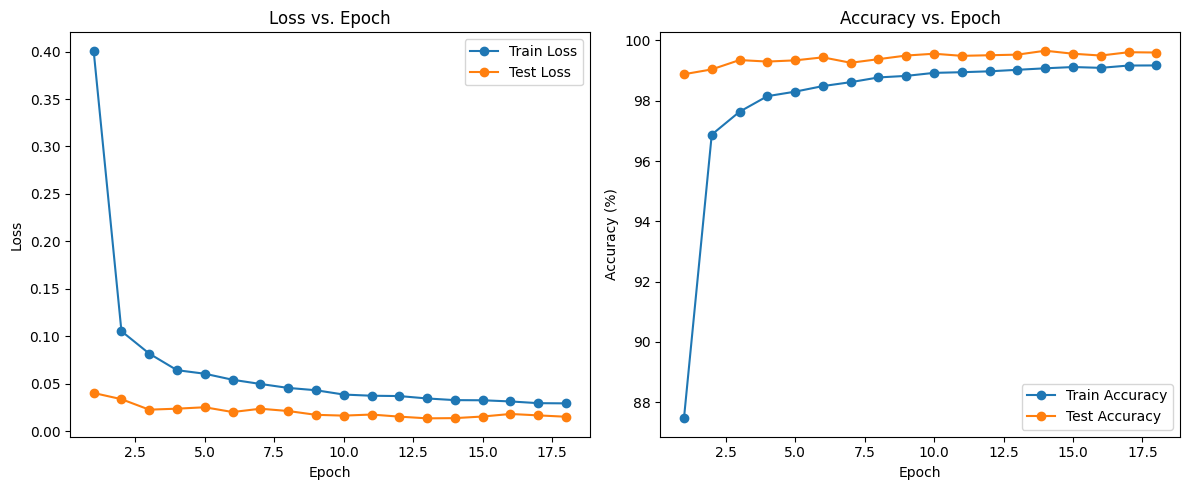

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train Epoch: 1 [0/61600 (0%)]	Loss: 2.301706
Train Epoch: 1 [640/61600 (1%)]	Loss: 2.239268
Train Epoch: 1 [1280/61600 (2%)]	Loss: 2.098335
Train Epoch: 1 [1920/61600 (3%)]	Loss: 2.188248
Train Epoch: 1 [2560/61600 (4%)]	Loss: 2.011747
Train Epoch: 1 [3200/61600 (5%)]	Loss: 1.703213
Train Epoch: 1 [3840/61600 (6%)]	Loss: 1.243940
Train Epoch: 1 [4480/61600 (7%)]	Loss: 1.128625
Train Epoch: 1 [5120/61600 (8%)]	Loss: 0.862501
Train Epoch: 1 [5760/61600 (9%)]	Loss: 0.890190
Train Epoch: 1 [6400/61600 (10%)]	Loss: 0.728814
Train Epoch: 1 [7040/61600 (11%)]	Loss: 0.652002
Train Epoch: 1 [7680/61600 (12%)]	Loss: 0.617869
Train Epoch: 1 [8320/61600 (13%)]	Loss: 0.386006
Train Epoch: 1 [8960/61600 (15%)]	Loss: 0.646384
Train Epoch: 1 [9600/61600 (16%)]	Loss: 0.401879
Train Epoch: 1 [10240/61600 (17%)]	Loss: 0.318712
Train Epoch: 1 [10880/61600 (18%)]	Loss: 1.048314
Train Epoch: 1 [11520/61600 (19%)]	Loss: 0.464716
Train Epoch: 1 [12160/61600 (20%)]	Loss: 0.694552
Train Epoch: 1 [12800/61600 (2

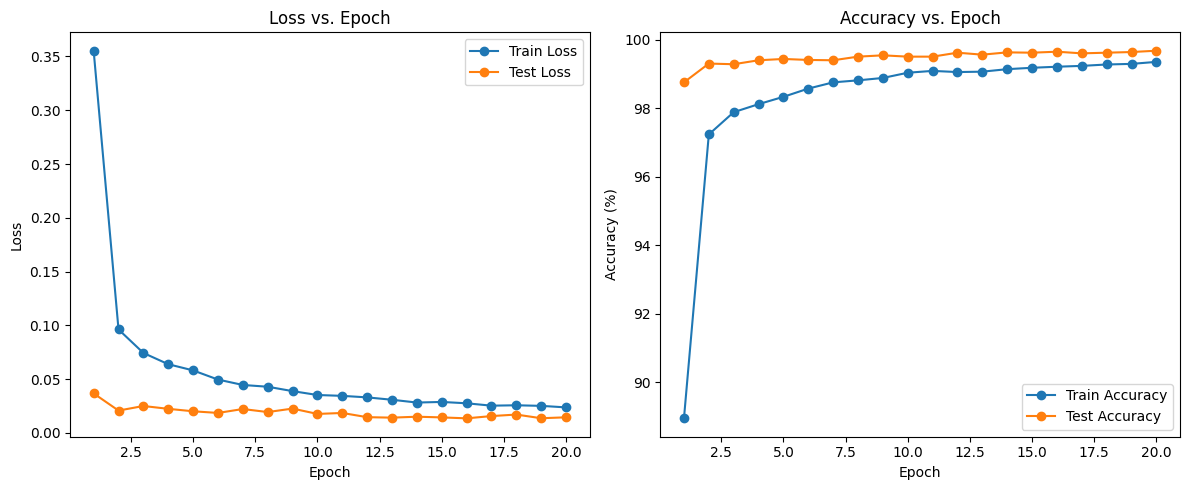

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
if __name__ == '__main__':
    main()